# Example: XGBoost power loss
This examples shows you how to load the trained XGBoost model and use it.

In [1]:
import os
from pathlib import Path

project_root = Path.cwd().parents[1]
os.chdir(project_root)   # now cwd is .../pvcracks

from pvcracks.powerloss.powerloss_functions import load_xgb_models, predict_power_and_voc
import numpy as np
import pandas as pd

#### Calculate delta Pmpp from fitted IV cell curves

In [2]:
Cell9Master = pd.read_csv('docs/data/ELdata_module_209_VAE_analysis.csv', index_col=0)

In [3]:
# grab each Module’s Init‐stage Pmp
init = (
    Cell9Master[Cell9Master['Deg']=='Init']
    .set_index('Module')['Pmp']
    # init is now a Series: index=Module, value=Pmp_at_Init
)

# Calcuate differenc in %
Cell9Master['deltaPmp'] = 100*(Cell9Master['Pmp'] - Cell9Master['Module'].map(init))/Cell9Master['Module'].map(init)

In [4]:
#Filter out specific cells we know have cracks
cracked = [
    ('209_A2','Deg1'),
    ('209_A1','Deg1'),
    ('209_A3','Deg2'),
    ('209_A1','Deg2'),
    ('209_C3','Deg2'),
    ('209_B2','Deg2'),
    ('209_B3','Deg2'),
]

# 2) build a boolean mask which is True only for those pairs
mask = Cell9Master[['Module','Deg']].apply(tuple,axis=1).isin(cracked)

# 3) slice to keep only the cracked cells
Cell9Degs = Cell9Master[mask].copy()

In [5]:
Cell9Degs

,ELPath,Module,Deg,Rs,Rsh,I,Is,N,Pmp,Vmp,Imp,lat_vec,klabel,deltaPmp
11,/docs/data/EL/209_A2/Deg1/209_A2_0005_2021_04_...,209_A2,Deg1,0.008996,1295.750000,8.228613,9.005018e-08,1.317542,3.534448,0.465455,7.593540,[ 5.0129116e-02 1.5392177e+00 1.2010708e+00 ...,4,-0.254354
12,/docs/data/EL/209_A1/Deg1/209_A1_0005_2021_04_...,209_A1,Deg1,0.010386,1.000000,8.184377,1.006196e-05,1.778587,3.051399,0.446061,6.840773,[ 0.1527828 0.6933546 0.61783403 -1.311733...,1,-13.414670
18,/docs/data/EL/209_A3/Deg2/209_A3_0005_2021_04_...,209_A3,Deg2,0.008634,8.986411,8.233849,6.987570e-06,1.730266,3.349300,0.458990,7.297111,[ 1.6261781e+00 -1.3577162e-01 3.6160046e-01 ...,4,-6.030860
21,/docs/data/EL/209_A1/Deg2/209_A1_0005_2021_04_...,209_A1,Deg2,0.012567,0.835178,7.588188,3.762260e-05,1.997049,2.678277,0.433131,6.183523,[-1.2965436 0.14127842 0.39876893 -0.320378...,1,-24.002233
23,/docs/data/EL/209_C3/Deg2/209_C3_0005_2021_04_...,209_C3,Deg2,0.009595,88.786965,8.160221,1.795159e-06,1.573030,3.347141,0.452525,7.396585,[-4.2912847e-01 2.1230426e+00 8.3105731e-01 ...,3,-3.268041
25,/docs/data/EL/209_B2/Deg2/209_B2_0005_2021_04_...,209_B2,Deg2,0.009456,529.959186,8.231207,3.558481e-06,1.644547,3.346776,0.452525,7.395777,[-0.2521562 0.70483327 1.0419804 -1.359632...,1,-4.311519
26,/docs/data/EL/209_B3/Deg2/209_B3_0005_2021_04_...,209_B3,Deg2,0.010031,97.047204,8.309195,1.610765e-06,1.567835,3.399534,0.452525,7.512363,[-1.8619239 1.6475563 1.0302961 -1.493011...,1,-4.495282


### Load latent vectors:
We show in the EL variational autoencoder (VAE) example "Rapid EL processing" how to obtain these.

In [6]:
#reformat latent vectors to np.array[np.array[],...]
def parse_whitespace_vec(s):
    # strip off the brackets, then split on any whitespace (incl newlines),
    # then convert each token to float
    nums = s.strip('[]').split()
    return [float(x) for x in nums]

# apply parsing
parsed = Cell9Degs['lat_vec'].apply(parse_whitespace_vec)

# 2) stack into a numpy array of dtype object
lat_vectors = np.array(parsed.tolist(), dtype=object)

### Load xgboost models:

In [7]:
pmpp_model, voc_model = load_xgb_models(
        pmpp_model_path="pvcracks/powerloss/xgb_model_pmpp_diff_percent_3CH.pkl",
        voc_model_path="pvcracks/powerloss/xgb_model_Voc_diff_percent_3CH.pkl"
    )

### Predict delta Pmpp in %

In [8]:
df_predictions = predict_power_and_voc(lat_vectors, pmpp_model, voc_model)

In [9]:
#power loss predictions added to cell info dataframe
Cell9Degs.loc[:, 'power_loss_%'] = df_predictions['power_loss_%'].values

In [10]:
Cell9Degs[['Module', 'Deg', 'deltaPmp', 'power_loss_%']]

,Module,Deg,deltaPmp,power_loss_%
11,209_A2,Deg1,-0.254354,-13.171658
12,209_A1,Deg1,-13.414670,-12.675356
18,209_A3,Deg2,-6.030860,-15.003642
21,209_A1,Deg2,-24.002233,-10.363716
23,209_C3,Deg2,-3.268041,-7.291249
25,209_B2,Deg2,-4.311519,-18.673622
26,209_B3,Deg2,-4.495282,-15.299884


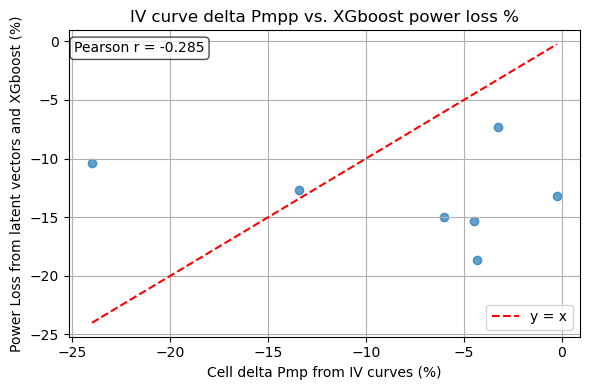

In [11]:
#Compare IV fit results vs XGboost
import matplotlib.pyplot as plt

x = Cell9Degs['deltaPmp']
y = Cell9Degs['power_loss_%']

# compute correlation
r = x.corr(y)

plt.figure(figsize=(6,4))
plt.scatter(x, y, alpha=0.7)
mn = min(x.min(), y.min())
mx = max(x.max(), y.max())
plt.plot([mn,mx], [mn,mx], 'r--', label='y = x')
plt.text(x.min()-0.9, 0, f"Pearson r = {r:.3f}", fontsize=10, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
plt.xlabel('Cell delta Pmp from IV curves (%)')
plt.ylabel('Power Loss from latent vectors and XGboost (%)')
plt.title('IV curve delta Pmpp vs. XGboost power loss %')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

The current results show a low pearson score (<0.3). This is due to our limited amount of EL/IV pairs that we could use to train the XGboost model, 77 pairs. In the powerloss subpackage there is a jupyter notebook going through the steps how the xgboost model is trained. This could be done with more data when made avaialable.